# Nearest-neighbour indexing using xoak

This notebook experiments subsetting datasets using `TLONG, TLAT, ULONG, ULAT` by making use of the [xoak](https://xoak.readthedocs.io/en/latest/) package

In [36]:
import matplotlib as mpl
import numpy as np
import xarray as xr
import xoak

import pop_tools

In [2]:
# open sample data
filepath = pop_tools.DATASETS.fetch('Pac_POP0.1_JRA_IAF_1993-12-6-test.nc')
ds = xr.open_dataset(filepath)

# get DZU and DZT, needed for operations later on
filepath_g = pop_tools.DATASETS.fetch('Pac_grid_pbc_1301x305x62.tx01_62l.2013-07-13.nc')
ds_g = xr.open_dataset(filepath_g)
ds.update(ds_g)

<xarray.Dataset>
Dimensions:            (bnds: 2, nlat: 305, nlon: 1301, time: 1, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time               (time) object 0036-12-07 00:00:00
    TLONG              (nlat, nlon) float64 ...
    ULAT               (nlat, nlon) float64 ...
  * z_t                (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
    TLAT               (nlat, nlon) float64 ...
    ULONG              (nlat, nlon) float64 ...
  * z_t_150m           (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot            (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top            (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: bnds, nlat, nlon
Data variables: (12/32)
    time_bnds          (time, bnds) object ...
    UAREA              (nlat, nlon) float64 ...
    TAREA              (nlat, nlon) float64 ...
    DXU                (nlat, nlon) float64 ...
    DYU                (nlat, nlon) float64 ...
    DXT                (nlat, nlon) float64 ...
    ...                 ...
    dzw                (z_w) float32 ...
    grav               float64 ...
    nsurface_t         float64 ...
    nsurface_u         float64 ...
    omega              float64 ...
    radius             float64 ...
Attributes: (12/13)
    CDI:               Climate Data Interface version 1.9.2 (http://mpimet.mp...
    history:           Tue Mar 24 11:51:32 2020: cdo selvar,UVEL,VVEL,DXT,DXU...
    source:            CCSM POP2, the CCSM Ocean Component
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    title:             g.e20.G.TL319_t13.control.001_hfreq
    time_period_freq:  day_5
    ...                ...
    contents:          Diagnostic and Prognostic Variables
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-12-14 at 16:05:58.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    CDO:               Climate Data Operators version 1.9.2 (http://mpimet.mp...

In [3]:
grid, xds = pop_tools.to_xgcm_grid_dataset(ds)

## Set the "index"

This is what allows the indexing magic.

In [7]:
xds.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')

## Extracting sections

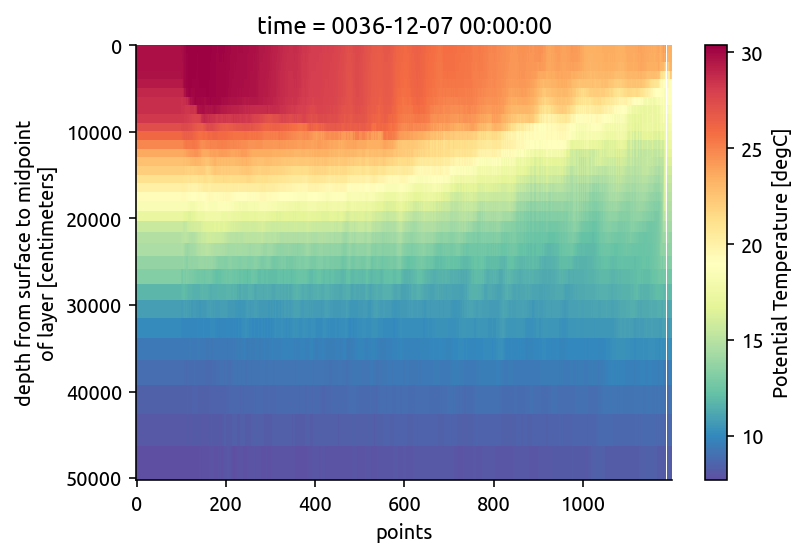

In [57]:
# have to know that 0.1 is a reasonable choice
lons = xr.Variable("points", np.arange(150, 270, 0.1))
lats = xr.zeros_like(lons)

eqsection = xds.xoak.sel(TLONG=lons, TLAT=lats)

# plot
eqsection.TEMP.sel(z_t=slice(50000)).plot(y="z_t", cmap=mpl.cm.Spectral_r, yincrease=False)

## Extracting multiple points

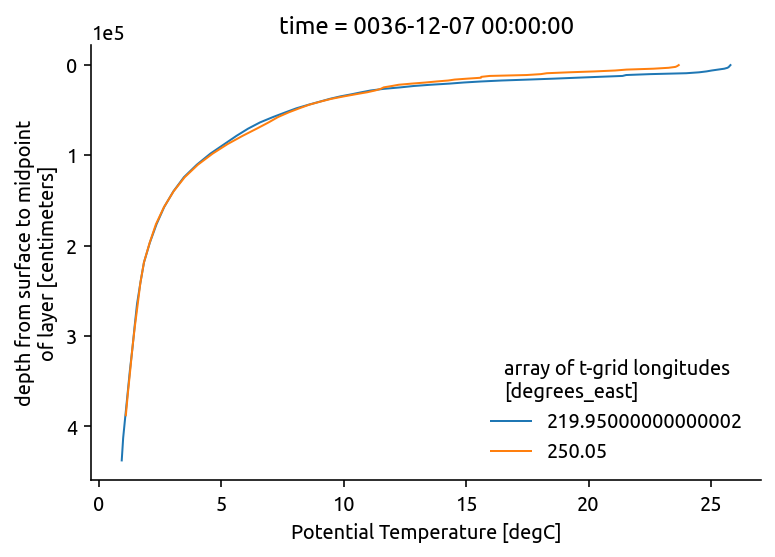

In [56]:
moorings = xds.xoak.sel(
    TLONG=xr.Variable("moor", [360 - 140, 360 - 110]),
    TLAT=xr.Variable("moor", [0, 0]),
)

moorings.TEMP.plot(hue="TLONG", y="z_t", yincrease=False)

## Extracting single points

In [63]:
xds.xoak.sel(TLONG=360 - 140, TLAT=0).TEMP

AttributeError: 'int' object has no attribute 'chunks'

xoak expectes "trajectories" to sample along. For a single point we create a 1D variable representing the coordinate location we want: in this case `TLONG=220, TLAT=0`. Seems like this could be fixed: https://github.com/xarray-contrib/xoak/issues/37

In [15]:
xds.xoak.sel(
    TLONG=xr.Variable("points", [360 - 140]), TLAT=xr.Variable("points", [0])
).TEMP.squeeze("points")

<xarray.DataArray 'TEMP' (time: 1, z_t: 62)>
array([[25.794353  , 25.759989  , 25.728874  , 25.674746  , 25.541134  ,
        25.282745  , 25.026842  , 24.813889  , 24.512192  , 23.9899    ,
        22.513605  , 21.532747  , 21.387815  , 20.417183  , 19.48939   ,
        18.584412  , 17.558277  , 16.449156  , 15.601459  , 14.897679  ,
        14.326382  , 13.539371  , 12.851948  , 12.320872  , 11.637564  ,
        11.112046  , 10.732501  , 10.340948  ,  9.864892  ,  9.434968  ,
         9.031752  ,  8.564738  ,  8.070933  ,  7.620849  ,  7.1164446 ,
         6.5846534 ,  6.0993133 ,  5.625975  ,  5.127931  ,  4.5544333 ,
         4.004363  ,  3.477641  ,  3.0496979 ,  2.6729817 ,  2.360019  ,
         2.0861135 ,  1.8473006 ,  1.6999204 ,  1.5623759 ,  1.4673579 ,
         1.3774252 ,  1.2729893 ,  1.1820002 ,  1.0894325 ,  0.99818563,
         0.9394488 ,         nan,         nan,         nan,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * time     (time) object 0036-12-07 00:00:00
    TLONG    float64 220.0
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    TLAT     float64 -0.05
    nlon_t   float64 600.5
    nlat_t   float64 152.5
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

## Limitations

- [ ] cannot simply index by point
- [ ] Can only set one index at a time (so only, TLONG, TLAT or ULONG, ULAT)
- [ ] indexes are not propagated so `xds.TEMP.xoak` will only work after `xds.TEMP.set_index` is called

In [13]:
xds.TEMP.xoak.sel(TLONG=220, TLAT=0)

ValueError: The index(es) has/have not been built yet. Call `.xoak.set_index()` first

In [12]:
xds.xoak.sel(TLONG=220, TLAT=0)

AttributeError: 'int' object has no attribute 'chunks'

In [58]:
%load_ext watermark
%watermark -d -iv -m -g

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.8.0-44-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: bd1236ca615b32595c43cfa689e85fc9a112eb9f

numpy     : 1.20.1
xoak      : 0.1.0
xarray    : 0.17.1.dev3+g48378c4b1
matplotlib: 3.3.4
pop_tools : 2020.12.15.post6+dirty

